In [21]:
import time
import six
import sys
sys.modules['sklearn.externals.six'] = six
import  mlrose
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import os
import seaborn as sns
import torch
import copy
import itertools
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import accuracy_score

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)


In [2]:
# read data from csv
df=pd.read_csv("heart.csv")
print(df.head()) #first 5 rows

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


In [3]:
#check string columns and update format from string to num
Sex=df['Sex'].unique()
print('Sex: ',Sex)

ChestPainType=df['ChestPainType'].unique()
print('ChestPainType: ',ChestPainType)

RestingECG=df['RestingECG'].unique()
print('RestingECG: ',RestingECG)

ExerciseAngina=df['ExerciseAngina'].unique()
print('ExerciseAngina: ',ExerciseAngina)

ST_Slope=df['ST_Slope'].unique()
print('ST_Slope: ',ST_Slope)

Sex:  ['M' 'F']
ChestPainType:  ['ATA' 'NAP' 'ASY' 'TA']
RestingECG:  ['Normal' 'ST' 'LVH']
ExerciseAngina:  ['N' 'Y']
ST_Slope:  ['Up' 'Flat' 'Down']


In [4]:
df['Sex']=df['Sex'].replace({'M':1,'F':0})
df['ChestPainType']=df['ChestPainType'].replace({'ATA':1,'NAP':2,'TA':3,'ASY':4})
df['RestingECG']=df['RestingECG'].replace({'Normal':1,'ST':2,'LVH':3})
df['ExerciseAngina']=df['ExerciseAngina'].replace({'Y':1,'N':0})
df['ST_Slope']=df['ST_Slope'].replace({'Up':1,'Flat':2,'Down':3})
print(df.head())

   Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   40    1              1        140          289          0           1   
1   49    0              2        160          180          0           1   
2   37    1              1        130          283          0           2   
3   48    0              4        138          214          0           1   
4   54    1              2        150          195          0           1   

   MaxHR  ExerciseAngina  Oldpeak  ST_Slope  HeartDisease  
0    172               0      0.0         1             0  
1    156               0      1.0         2             1  
2     98               0      0.0         1             0  
3    108               1      1.5         2             1  
4    122               0      0.0         1             0  


In [5]:
df=df.drop(df['RestingBP'][df['RestingBP']==0].index)
df=df.drop(df['Cholesterol'][df['Cholesterol']==0].index)

In [6]:
X = df.values[:,:-2] #columns and rows
y = df.values[:,-1] #target column
print("Number of positive samples: ", (y==1).sum())
print("Number of negative samples: ", (y==0).sum())
print("y shape: ", y.shape)
print("X shape: ", X.shape)

Number of positive samples:  356
Number of negative samples:  390
y shape:  (746,)
X shape:  (746, 10)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y_train.sum(), y_test.sum()


(243.0, 113.0)

In [8]:

print(X_train)

[[ 54.    1.    4.  ... 140.    0.    0. ]
 [ 53.    1.    2.  ... 160.    0.    0.3]
 [ 60.    1.    4.  ... 140.    1.    0.5]
 ...
 [ 45.    1.    4.  ... 140.    0.    0. ]
 [ 53.    1.    4.  ... 128.    1.    1.5]
 [ 40.    0.    4.  ... 130.    0.    2. ]]


In [20]:
## 2. Neural networks

In [9]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
# Standardizing
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# DataLoader
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

In [12]:
# Neural Network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(50, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

model = NeuralNetwork(X_train.shape[1]).to(device)

In [13]:
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 30
for epoch in tqdm(range(num_epochs)):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 30/30 [00:00<00:00, 140.24it/s]


In [14]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test).squeeze()
    y_pred_labels = y_pred.round()
    test_auc = roc_auc_score(y_test.cpu(), y_pred_labels.cpu())
    print(f'Test ROC AUC Score: {test_auc}')

Test ROC AUC Score: 0.804113848361636


In [41]:
# RHC
# Initialize lists to store results
y_test_f1_rhc = [] #F1 score
y_train_f1_rhc = [] 
y_test_accuracy_rhc = [] #Accuracy
y_train_accuracy_rhc = []
Running_time_rhc = []
iterations = [20, 50, 100, 200, 300, 500, 1000]  #pre-define iterations

# Train and evaluate the model for each combination of iterations
for i in iterations:
    y_train_f1 = []
    y_train_accuracy = []
    y_test_f1 = []
    y_test_accuracy = []
    Running_time_final = []
    
    for j in iterations:
        start_time = time.time()
        nn_model_rhc = mlrose.NeuralNetwork(hidden_nodes=[25], activation='relu', algorithm='random_hill_climb', 
                                             max_iters=i, max_attempts=j, learning_rate=0.01, early_stopping=True, 
                                             clip_max=10, random_state=42, restarts=6, curve=True) #best LR was 0.01 in Assignment1
        nn_model_rhc.fit(X_train, y_train)
        
        # Predict labels for train set and assess accuracy
        train_pred = nn_model_rhc.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_pred)
        train_f1 = f1_score(y_train, train_pred, average='macro')
        y_train_accuracy.append(train_accuracy)
        y_train_f1.append(train_f1)
        
        # Predict labels for test set and assess accuracy
        test_pred = nn_model_rhc.predict(X_test)
        test_accuracy = accuracy_score(y_test, test_pred)
        test_f1 = f1_score(y_test, test_pred, average='macro')
        y_test_accuracy.append(test_accuracy)
        y_test_f1.append(test_f1)
        
        # Running time
        stop_time = time.time()
        Running_time = stop_time - start_time
        Running_time_final.append(Running_time)
        
    y_train_accuracy_rhc.append(y_train_accuracy)
    y_test_accuracy_rhc.append(y_test_accuracy)
    y_train_f1_rhc.append(y_train_f1)
    y_test_f1_rhc.append(y_test_f1)
    Running_time_rhc.append(Running_time_final)

In [15]:
def plot_validation_accuracy(iteration, y_train, y_test): 
    iteration=[20,50,100,200,300,500,1000]

    plt.title(title)
    plt.xlabel("Number of Iterations")
    plt.ylabel("Score")
    plt.plot(iteration, y_train, label="Train score",color="red",marker='.', lw=2)
    plt.plot(iteration, y_test, label="Test score",color="blue",marker='.', lw=2)
    plt.legend(loc="best")
    plt.show()

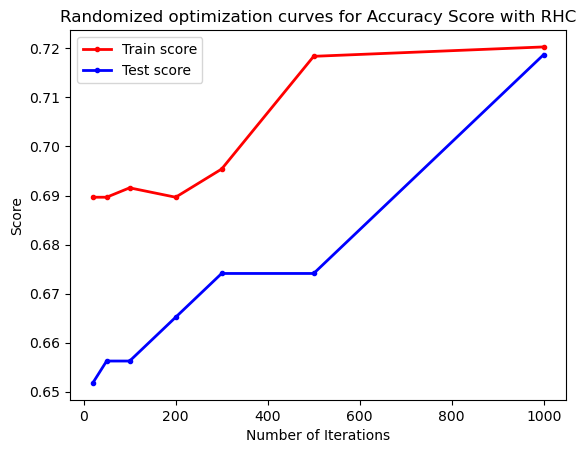

In [43]:
y_train_accuracy = np.mean(y_train_accuracy_rhc,axis =1)
y_test_accuracy = np.mean(y_test_accuracy_rhc,axis =1)
title = 'Randomized optimization curves for Accuracy Score with RHC'
plot_validation_accuracy(iteration,y_train_accuracy,y_test_accuracy)

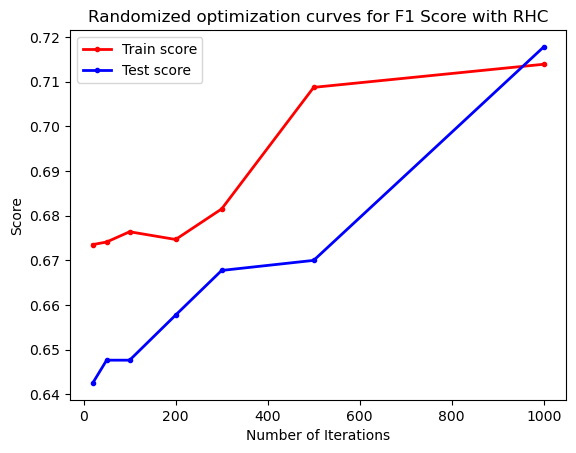

In [44]:
y_train_f1 = np.mean(y_train_f1_rhc,axis =1)
y_test_f1 = np.mean(y_test_f1_rhc,axis =1)
title = 'Randomized optimization curves for F1 Score with RHC'
plot_validation_accuracy(iteration,y_train_f1,y_test_f1)

Text(0, 0.5, 'Running time')

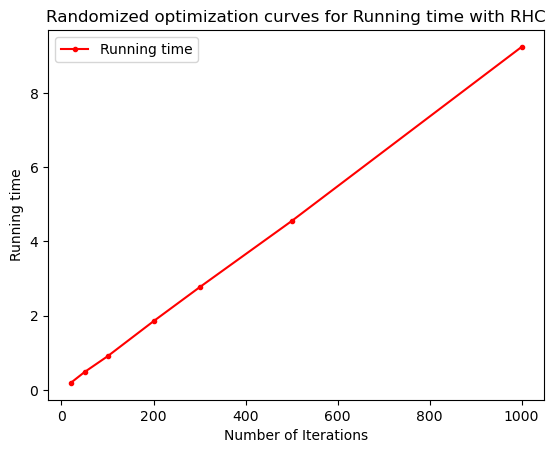

In [49]:
Running_time_rhc_mean = np.mean(Running_time_rhc,axis = 1)
iteration=[20,50,100,200,300,500,1000]
plt.plot(iteration,Running_time_rhc_mean, '.-', color="r",label="Running time")
plt.legend(loc="best")
plt.title('Randomized optimization curves for Running time with RHC')
plt.xlabel("Number of Iterations")
plt.ylabel("Running time")

In [54]:
# SA
# Initialize lists to store results
y_test_f1_sa = [] #F1 score
y_train_f1_sa = [] 
y_test_accuracy_sa = [] #Accuracy
y_train_accuracy_sa = []
Running_time_sa = []
iterations = [20, 50, 100, 200, 300, 500, 1000]  #pre-define iterations

# Train and evaluate the model for each combination of iterations
for i in iterations:
    y_train_f1 = []
    y_train_accuracy = []
    y_test_f1 = []
    y_test_accuracy = []
    Running_time_final = []
    
    for j in iterations:
        start_time = time.time()
        nn_model_sa = mlrose.NeuralNetwork(hidden_nodes=[25], activation='relu', algorithm='simulated_annealing', 
                                             max_iters=i, max_attempts=j, learning_rate=0.01, early_stopping=True, 
                                             clip_max=10, random_state=42, restarts=6, curve=True) #best LR was 0.01 in Assignment1
        nn_model_sa.fit(X_train, y_train)
        
        # Predict labels for train set and assess accuracy
        train_pred = nn_model_sa.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_pred)
        train_f1 = f1_score(y_train, train_pred, average='macro')
        y_train_accuracy.append(train_accuracy)
        y_train_f1.append(train_f1)
        
        # Predict labels for test set and assess accuracy
        test_pred = nn_model_sa.predict(X_test)
        test_accuracy = accuracy_score(y_test, test_pred)
        test_f1 = f1_score(y_test, test_pred, average='macro')
        y_test_accuracy.append(test_accuracy)
        y_test_f1.append(test_f1)
        
        # Running time
        stop_time = time.time()
        Running_time = stop_time - start_time
        Running_time_final.append(Running_time)
        
    y_train_accuracy_sa.append(y_train_accuracy)
    y_test_accuracy_sa.append(y_test_accuracy)
    y_train_f1_sa.append(y_train_f1)
    y_test_f1_sa.append(y_test_f1)
    Running_time_sa.append(Running_time_final)

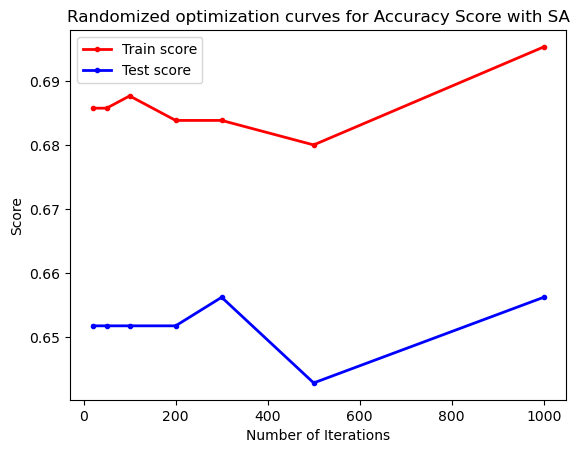

In [51]:
y_train_accuracy = np.mean(y_train_accuracy_sa,axis =1)
y_test_accuracy = np.mean(y_test_accuracy_sa,axis =1)
title = 'Randomized optimization curves for Accuracy Score with SA'
plot_validation_accuracy(iteration,y_train_accuracy,y_test_accuracy)

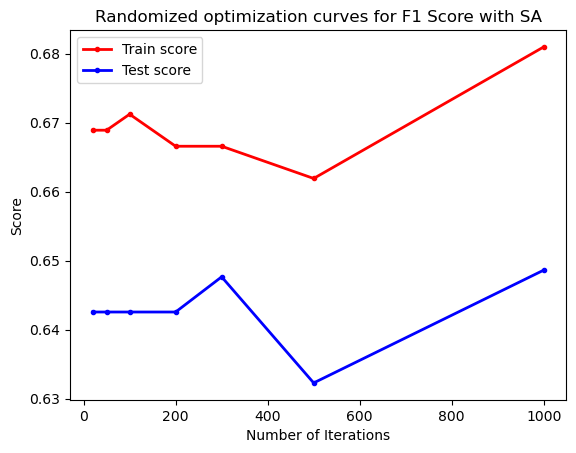

In [52]:
y_train_f1 = np.mean(y_train_f1_sa,axis =1)
y_test_f1 = np.mean(y_test_f1_sa,axis =1)
title = 'Randomized optimization curves for F1 Score with SA'
plot_validation_accuracy(iteration,y_train_f1,y_test_f1)

Text(0, 0.5, 'Running time')

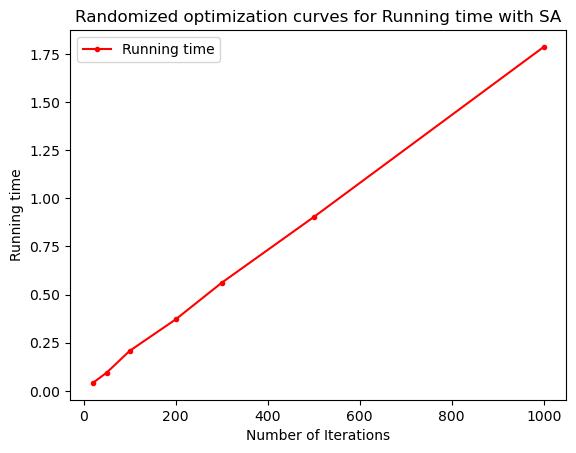

In [55]:
Running_time_sa_mean = np.mean(Running_time_sa,axis = 1)
iteration=[20,50,100,200,300,500,1000]
plt.plot(iteration,Running_time_sa_mean, '.-', color="r",label="Running time")
plt.legend(loc="best")
plt.title('Randomized optimization curves for Running time with SA')
plt.xlabel("Number of Iterations")
plt.ylabel("Running time")

In [39]:
# Initialize neural network object and fit object - genetic algorithm with learning_rate = 0.000005, mutation_prob = 0.4,pop_size = 300

y_test_accuracy_ga = []
y_train_accuracy_ga = []
y_train_f1_ga = []
y_test_f1_ga = []
running_time_ga = []
iteration=[20,50,100,200,300]

for i in iteration:
    y_train_f1 = []
    y_test_f1= []
    y_train_accuracy= []
    y_test_accuracy = []
    wall_clock_time_final = []
   
    for j in iteration:
        
        start_time = time.time()
        nn_model_ga = mlrose.NeuralNetwork(hidden_nodes = [25], activation ='sigmoid', algorithm ='genetic_alg', 
                                         max_iters = i, max_attempts = j,learning_rate = 0.000005, early_stopping = True, 
                                        mutation_prob = 0.1,pop_size = 300,
                                         clip_max = 10, random_state = 42,curve = True)
        
        
        nn_model_ga.fit(X_train, y_train)
        
        # Predict labels for train set and assess accuracy
        train_pred = nn_model_ga.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_pred)
        train_f1 = f1_score(y_train, train_pred, average='macro')
        y_train_accuracy.append(train_accuracy)
        y_train_f1.append(train_f1)
        
        # Predict labels for test set and assess accuracy
        test_pred = nn_model_ga.predict(X_test)
        test_accuracy = accuracy_score(y_test, test_pred)
        test_f1 = f1_score(y_test, test_pred, average='macro')
        y_test_accuracy.append(test_accuracy)
        y_test_f1.append(test_f1)
        
        # Running time
        stop_time = time.time()
        Running_time = stop_time - start_time
        Running_time_final.append(Running_time)
        
    y_train_accuracy_ga.append(y_train_accuracy)
    y_test_accuracy_ga.append(y_test_accuracy)
    y_train_f1_ga.append(y_train_f1)
    y_test_f1_ga.append(y_test_f1)
    Running_time_ga.append(Running_time_final)

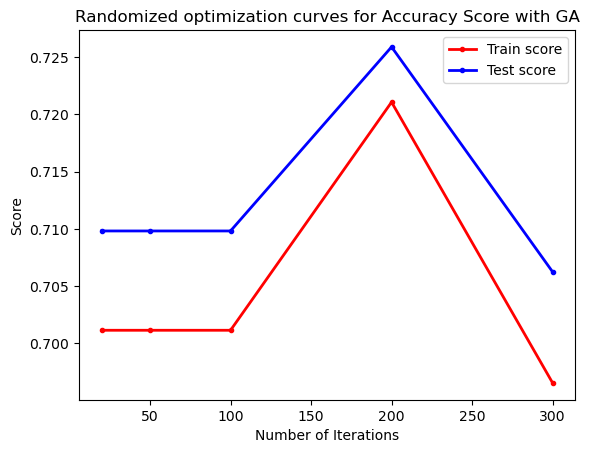

In [60]:
def plot_validation_accuracy(iteration, y_train, y_test): 
    iteration=[20,50,100,200,300]

    plt.title(title)
    plt.xlabel("Number of Iterations")
    plt.ylabel("Score")
    plt.plot(iteration, y_train, label="Train score",color="red",marker='.', lw=2)
    plt.plot(iteration, y_test, label="Test score",color="blue",marker='.', lw=2)
    plt.legend(loc="best")
    plt.show()




# Assuming y_train_accuracy_ga and y_test_accuracy_ga are 2D arrays with shape (len(iteration), num_experiments)
y_train_accuracy = np.mean(y_train_accuracy_ga, axis=1)
y_test_accuracy = np.mean(y_test_accuracy_ga, axis=1)
iteration = [20, 50, 100, 200, 300]
title = 'Randomized optimization curves for Accuracy Score with GA'

plot_validation_accuracy(iteration, y_train_accuracy, y_test_accuracy)

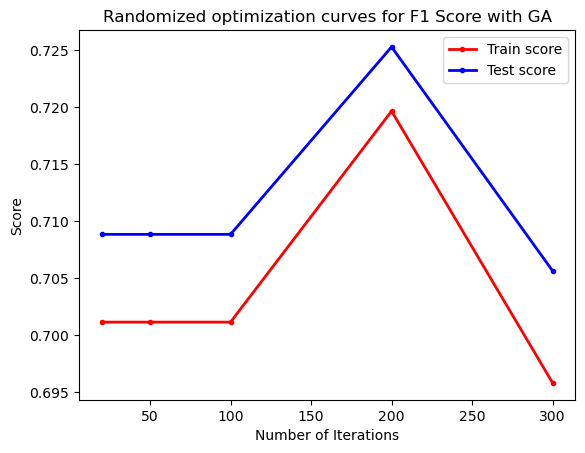

In [61]:
y_train_f1 = np.mean(y_train_f1_ga,axis =1)
y_test_f1 = np.mean(y_test_f1_ga,axis =1)
title = 'Randomized optimization curves for F1 Score with GA'
plot_validation_accuracy(iteration,y_train_f1,y_test_f1)